In [1]:
import os
import pickle
import sys
import warnings
from glob import glob
import re
import datetime
from tqdm import tqdm
from google_trans_new import google_translator  
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
from mpl_finance import candlestick2_ohlc, volume_overlay
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm
import talib

In [2]:
dataset_dir="../data_dir/"

In [3]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


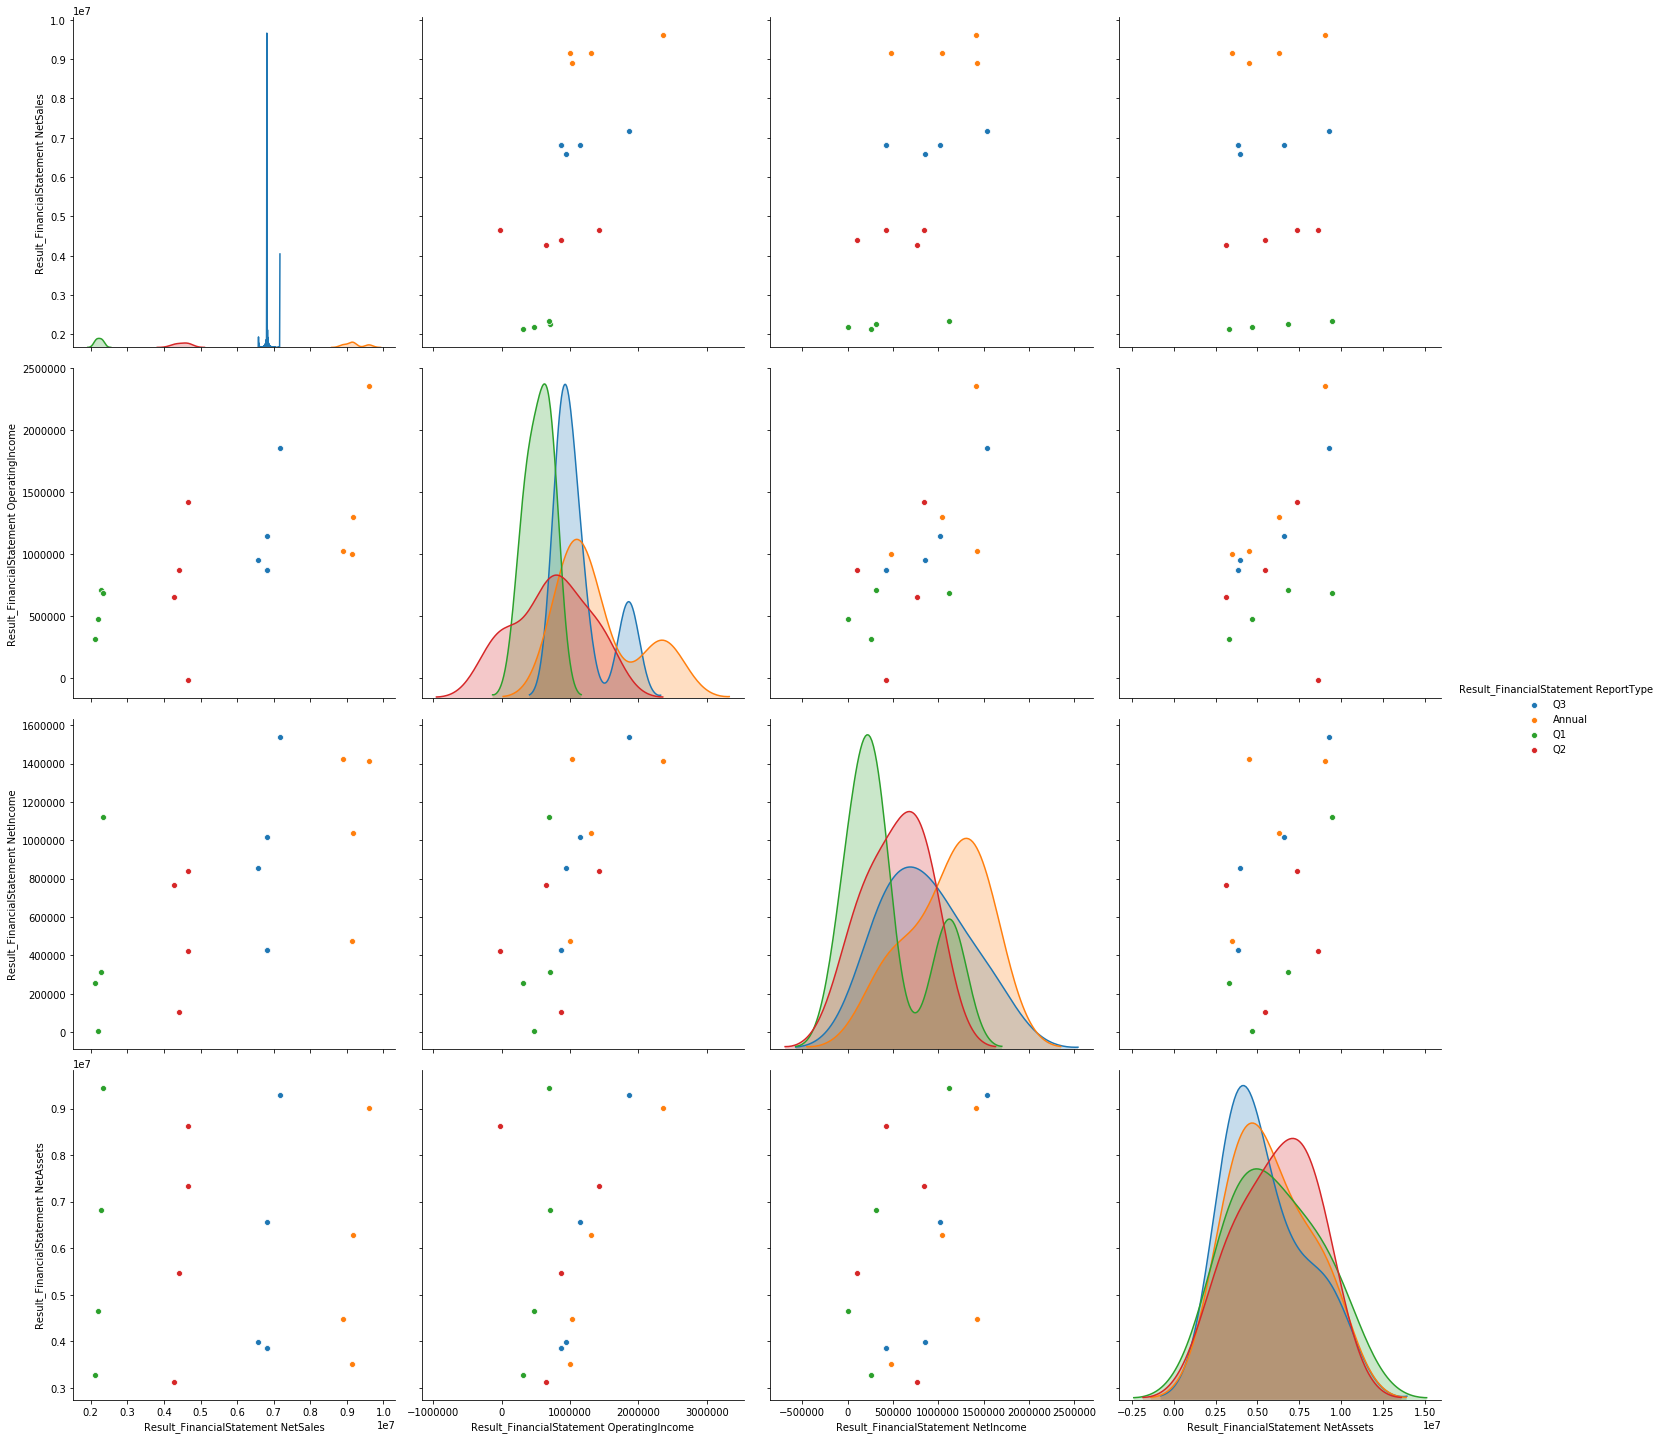

In [4]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
fin_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

In [5]:
# translator = google_translator()
# for key in dfs:
#     print(key)
#     if key =="stock_fin":
#         print(type(key))
#         a =[]
#         #key = "stock_fin"
#         for column in dfs[key].columns:
#             m=re.sub( r"([A-Z])", r" \1", column)
#             m=re.split('[_]', m)
#             m1=["" if s == " Result" else "来年の" if s==" Forecast" else s for s in m]
#             #print(m1)
#             m1=" ".join(m1)
#             m1=m1.lower()
#             #print(m1)
#             #'negative' if a < 0 else 'positive' if a > 0 else 'zero'
#             new_column=translator.translate(m1, lang_src='en', lang_tgt='ja').strip()
#             dfs[key].rename(columns={column:new_column},inplace=True)
#             a.append(new_column)
#             #df.rename(columns={'A': 'a'}, index={'ONE': 'one'})
#         print(a)

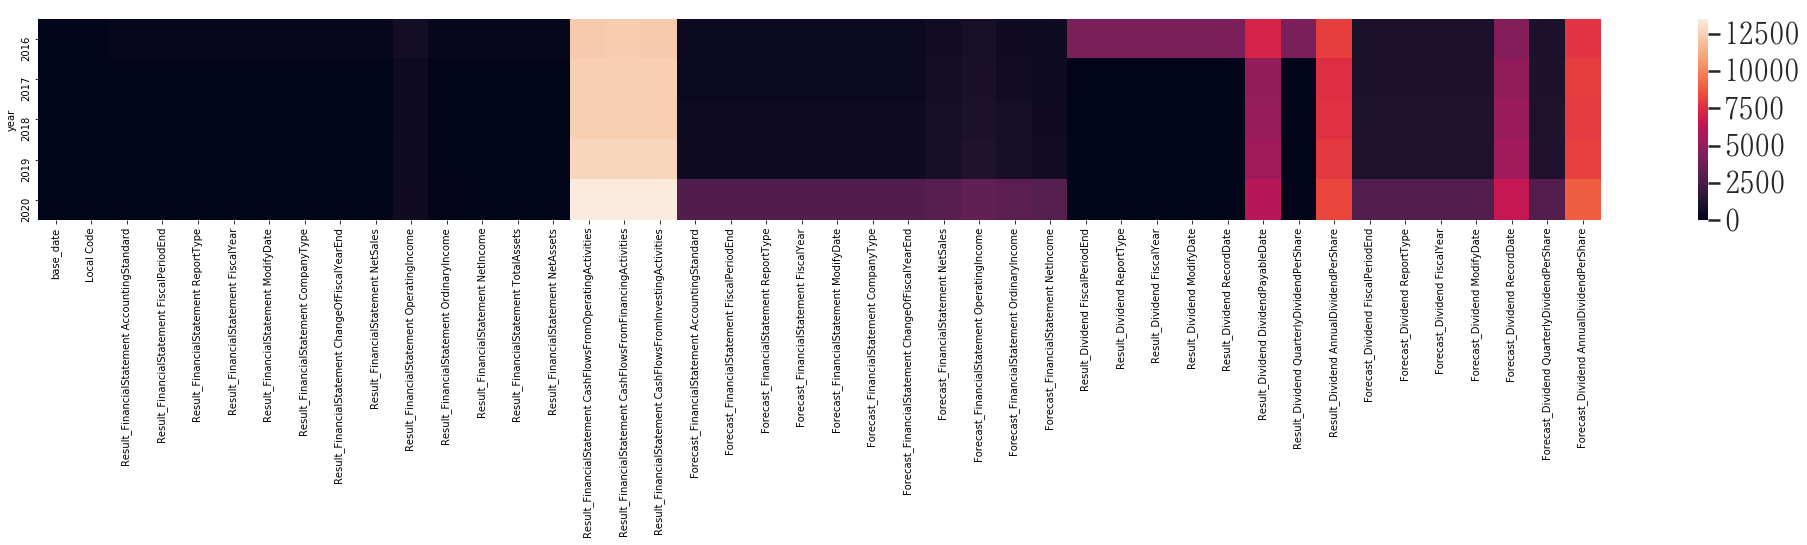

In [6]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 2019年までの値を表示
#stock_fin = stock_fin[:"2019"]

# データの欠損値数を確認
#print(stock_fin.isna().sum())
# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year
stock_fin
# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(35, 35))
matplotlib.font_manager._rebuild()
sns.set(font='TakaoMincho')
sns.set_context("poster", font_scale=1.4)
fig.subplots_adjust(bottom=0.8)
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)
plt.savefig("Missing_value.png")
stock_fin = dfs["stock_fin"]

In [7]:
# stock_fin_annual = stock_fin[stock_fin["財務諸表レポートタイプ"]=="Annual"]
# # プロット対象を定義
# columns = [
#     "財務諸表売上高",
#     "財務諸表の営業利益",
#     "財務諸表経常利益",
#     "財務諸表の純利益",
#     "財務諸表の総資産",
#     "財務諸表純資産"
# ]
# plt.close()
# sns.set_context("paper", font_scale=1.4)
# report="Annual"
# pg=sns.pairplot(stock_fin_annual,vars=columns,hue="財務諸表会社タイプ",diag_kind="None",palette={'GB': 'blue','SE': 'green','BK': 'orange','IN': 'red'})
# pg.savefig("./quarter/" + str(report) + ".png")

KeyError: '財務諸表売上高'

In [7]:
# stock_fin_annual = stock_fin[stock_fin["財務諸表レポートタイプ"]=="Annual"]
# # プロット対象を定義
# columns = [
#     "財務諸表売上高",
#     "財務諸表の営業利益",
#     "財務諸表経常利益",
#     "財務諸表の純利益",
#     "財務諸表の総資産",
#     "財務諸表純資産"
# ]
# plt.close()
# sns.set_context("paper", font_scale=1.4)
# report="Annual"
# pg=sns.pairplot(stock_fin_annual,vars=columns,hue="財務諸表会社タイプ",diag_kind="None",palette={'GB': 'blue','SE': 'green','BK': 'orange','IN': 'red'})
# pg.savefig("./quarter/" + str(report) + ".png")
print(stock_fin.select_dtypes(include=[float]).columns)
print(stock_fin.select_dtypes(include=[object]).columns)

Index(['Result_FinancialStatement FiscalYear',
       'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome',
       'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome',
       'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets',
       'Result_FinancialStatement CashFlowsFromOperatingActivities',
       'Result_FinancialStatement CashFlowsFromFinancingActivities',
       'Result_FinancialStatement CashFlowsFromInvestingActivities',
       'Forecast_FinancialStatement FiscalYear',
       'Forecast_FinancialStatement NetSales',
       'Forecast_FinancialStatement OperatingIncome',
       'Forecast_FinancialStatement OrdinaryIncome',
       'Forecast_FinancialStatement NetIncome', 'Result_Dividend FiscalYear',
       'Result_Dividend QuarterlyDividendPerShare',
       'Result_Dividend AnnualDividendPerShare',
       'Forecast_Dividend FiscalYear',
       'Forecast_Dividend QuarterlyDi

In [8]:
# stock_fin_annual = stock_fin[stock_fin["財務諸表レポートタイプ"]=="Annual"]
# # プロット対象を定義
# x_columns = [
#     "財務諸表売上高",
#     "財務諸表の純利益",
#     "財務諸表純資産",
#     #"営業活動による財務諸表のキャッシュフロー",
#     #"財務活動による財務諸表のキャッシュフロー",
#     #"投資活動による財務諸表のキャッシュフロー",
# ]
# y_columns = [
#     "営業活動による財務諸表のキャッシュフロー",
#     "財務活動による財務諸表のキャッシュフロー",
#     "投資活動による財務諸表のキャッシュフロー",
# ]
# plt.close()
# sns.set_context("paper", font_scale=1.4)
# report="Annual"
# pg=sns.pairplot(stock_fin_annual,x_vars=x_columns,y_vars=y_columns,hue="財務諸表会社タイプ",
#                 palette={'GB': 'blue','SE': 'green','BK': 'orange','IN': 'red'},
#                 height=5, aspect=0.5)
# #pg.savefig("./quarter/" + str(report) + ".png")

In [10]:
stock_price = dfs["stock_price"]
stock_labels = dfs["stock_labels"]


In [11]:
stock_price.columns

Index(['Local Code', 'EndOfDayQuote Date', 'EndOfDayQuote Open',
       'EndOfDayQuote High', 'EndOfDayQuote Low', 'EndOfDayQuote Close',
       'EndOfDayQuote ExchangeOfficialClose', 'EndOfDayQuote Volume',
       'EndOfDayQuote CumulativeAdjustmentFactor',
       'EndOfDayQuote PreviousClose', 'EndOfDayQuote PreviousCloseDate',
       'EndOfDayQuote PreviousExchangeOfficialClose',
       'EndOfDayQuote PreviousExchangeOfficialCloseDate',
       'EndOfDayQuote ChangeFromPreviousClose',
       'EndOfDayQuote PercentChangeFromPreviousClose', 'EndOfDayQuote VWAP'],
      dtype='object')

In [12]:
stock_labels=stock_labels[["base_date","Local Code","label_high_20","label_low_20"]]
stock_labels.rename(columns={"base_date":"基準日","Local Code":"ローカルコード"},inplace=True)
stock_fin["基準日"] = pd.to_datetime(stock_fin["基準日"])


In [13]:
stock_labels["基準日"] = pd.to_datetime(stock_labels["基準日"])
train_X = pd.merge(stock_labels, stock_fin,on=['基準日',"ローカルコード"])

In [14]:
# code, start(datetime型), end(datetime型)を指定してOHLCVを取得
def get_data_for_plot(code, start, end):
    tmp_df = stock_price.copy()
    tmp_df = tmp_df[tmp_df["Local Code"]==code]
    tmp_df["datetime"] = pd.to_datetime(tmp_df["EndOfDayQuote Date"])
    tmp_df = tmp_df.set_index("datetime")
    tmp_df = tmp_df[(tmp_df.index>=start) & (tmp_df.index<=end)]
    tmp_feat = ["EndOfDayQuote Open", "EndOfDayQuote High", "EndOfDayQuote Low", "EndOfDayQuote Close", "EndOfDayQuote Volume"]
    tmp_df = tmp_df[tmp_feat]
    tmp_df.columns = ["open", "high", "low", "close", "volume"]
    return tmp_df

In [15]:
# 8つのOHLCVチャートを描画します
def plot_ohlcv1(codes, plot_dfs):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(18,15))
    for i in range(8):
        candlestick2_ohlc(ax[int(i/2), i%2], plot_dfs[i]["open"], plot_dfs[i]["high"], plot_dfs[i]["low"], plot_dfs[i]["close"], width=0.9, colorup="b", colordown="r")
        ax[int(i/2), i%2].set_xticklabels([plot_dfs[i].index[d].strftime("%y/%m/%d") for d in range(0, len(plot_dfs[i]), 7)])
        ax[int(i/2), i%2].xaxis.set_major_locator(DayLocator(interval=7))
        ax[int(i/2), i%2].set_ylabel("price")
        bottom, top = ax[int(i/2), i%2].get_ylim()
        ax[int(i/2), i%2].set_ylim(bottom - (top - bottom) / 4, top)
        ax[int(i/2), i%2].set_title(str(codes[i]))
        ax2 = ax[int(i/2), i%2].twinx()
        volume_overlay(ax2, plot_dfs[i]["open"], plot_dfs[i]["close"], plot_dfs[i]["volume"], width=1, colorup="g", colordown="g")
        ax2.set_ylim([0, plot_dfs[i]["volume"].max() * 4])
        ax2.set_ylabel("volume")

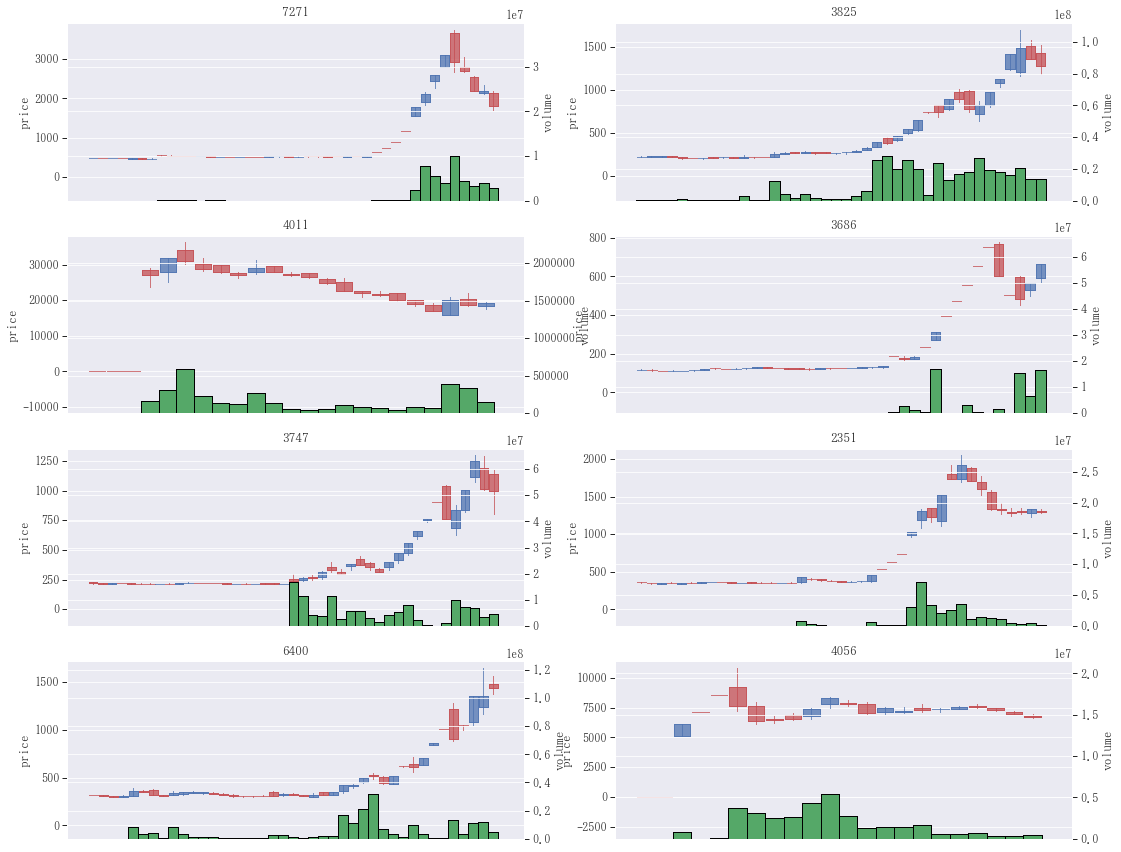

In [16]:
tmp_df = train_X.sort_values("label_high_20", ascending=False)[:8]  # labelの上位8データを取得
codes = [tmp_df["ローカルコード"].iloc[i] for i in range(len(tmp_df))]
dates = [tmp_df["基準日"].iloc[i] for i in range(len(tmp_df))]
# print(tmp_df)
# print(codes)
# print(dates)
plot_dfs = [get_data_for_plot(codes[i], dates[i]-datetime.timedelta(days=30), dates[i]+datetime.timedelta(days=30)) for i in range(len(tmp_df))]
plot_ohlcv1(codes, plot_dfs)

In [17]:
stock_price.head()

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
datetime,,,,,,,,,,,,,,,,
2016-01-04,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
2016-01-05,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2016-01-06,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867
2016-01-07,1301,2016/01/07,2740.0,2760.0,2710.0,2710.0,2710.0,31400.0,0.1,2760.0,2016/01/06,2760.0,2016/01/06,-50.0,-1.812,2733.471
2016-01-08,1301,2016/01/08,2700.0,2740.0,2690.0,2700.0,2700.0,26200.0,0.1,2710.0,2016/01/07,2710.0,2016/01/07,-10.0,-0.369,2709.122


In [18]:
train_X.head()

,基準日,ローカルコード,label_high_20,label_low_20,財務諸表会計基準,財務諸表会計期末,財務諸表レポートタイプ,財務諸表会計年度,財務諸表の変更日,財務諸表会社タイプ,...,配当配当支払日,配当四半期配当1株当たり,配当1株当たり年間配当,来年の配当決算,来年の配当レポートタイプ,来年の配当年度,来年の配当変更日,来年の配当基準日,来年配当1株当たり四半期配当,来年配当1株当たり年間配当
0,2016-02-05,1301,0.03019,-0.05660,ConsolidatedJP,2015/12,Q3,2016.0,2016/02/05,GB,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/02/05,2016/03/31,5.0,5.0
1,2016-05-09,1301,0.03448,-0.01149,ConsolidatedJP,2016/03,Annual,2016.0,2016/05/09,GB,...,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/05/09,2017/03/31,50.0,50.0
2,2016-08-05,1301,0.02692,0.00000,ConsolidatedJP,2016/06,Q1,2017.0,2016/08/05,GB,...,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/08/05,2017/03/31,50.0,50.0
3,2016-11-04,1301,0.00779,-0.03967,ConsolidatedJP,2016/09,Q2,2017.0,2016/11/04,GB,...,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/11/04,2017/03/31,50.0,50.0
4,2017-02-10,1301,0.15665,0.00401,ConsolidatedJP,2016/12,Q3,2017.0,2017/02/10,GB,...,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2017/02/10,2017/03/31,50.0,50.0


In [19]:
dfs["stock_list"]["Size (New Index Series)"].unique()

array(['TOPIX Small 2', 'TOPIX Mid400', 'TOPIX Small 1', '-',
       'TOPIX Large70', 'TOPIX Core30'], dtype=object)

In [20]:
stock_list = dfs["stock_list"]
stock_list[stock_list["Local Code"] == 1301]

,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0


In [21]:
stock_list["Local Code"].nunique() / len(stock_list)

1.0

In [22]:
def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["ローカルコード"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats,fin_data

In [23]:
df,fin_data_1 = get_features_for_predict(dfs, 9984)
df.head()
fin_data_1.head(20)

,財務諸表会計年度,財務諸表売上高,財務諸表の営業利益,財務諸表経常利益,財務諸表の純利益,財務諸表の総資産,財務諸表純資産,営業活動による財務諸表のキャッシュフロー,財務活動による財務諸表のキャッシュフロー,投資活動による財務諸表のキャッシュフロー,...,来年の財務諸表売上高,来年の財務諸表営業利益,来年の財務諸表経常利益,来年の財務諸表純利益,配当年度,配当四半期配当1株当たり,配当1株当たり年間配当,来年の配当年度,来年配当1株当たり四半期配当,来年配当1株当たり年間配当
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-10,2016.0,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0,20.0,40.0
2016-04-21,2016.0,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0,21.0,41.0
2016-05-10,2016.0,9153549.0,999488.0,1005764.0,474172.0,20707192.0,3505271.0,940186.0,43270.0,-1651682.0,...,NaN,NaN,NaN,NaN,2016.0,21.0,41.0,2017.0,22.0,NaN
2016-07-28,2017.0,2126521.0,319236.0,356361.0,254157.0,20622229.0,3271996.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016.0,21.0,41.0,2017.0,22.0,NaN
2016-11-07,2017.0,4271834.0,653944.0,665625.0,766249.0,22896077.0,3126322.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,22.0,NaN,2017.0,22.0,44.0
2017-02-08,2017.0,6581466.0,949660.0,975257.0,857431.0,24867038.0,3981711.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,22.0,NaN,2017.0,22.0,44.0
2017-05-10,2017.0,8901004.0,1025999.0,712526.0,1426308.0,24634212.0,4469730.0,1500728.0,2380746.0,-4213597.0,...,NaN,NaN,NaN,NaN,2017.0,22.0,44.0,2018.0,22.0,NaN
2017-08-07,2018.0,2186059.0,479273.0,77568.0,5521.0,24883131.0,4654749.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,22.0,44.0,2018.0,22.0,NaN
2017-11-06,2018.0,4411135.0,874839.0,219021.0,102622.0,27973483.0,5468373.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2018.0,22.0,NaN,2018.0,22.0,44.0


In [24]:
df.head()

,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month,財務諸表会計年度,...,来年の財務諸表営業利益,来年の財務諸表経常利益,来年の財務諸表純利益,配当年度,配当四半期配当1株当たり,配当1株当たり年間配当,来年の配当年度,来年配当1株当たり四半期配当,来年配当1株当たり年間配当,code
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-10,-0.191321,0.000000,0.000000,0.044026,0.000000,0.000000,0.910719,0.000000,0.000000,2016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,20.0,40.0,9984
2016-04-21,0.089088,0.144146,0.255517,0.017177,0.017050,0.034284,1.071322,1.067462,1.110128,2016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,21.0,41.0,9984
2016-05-10,0.086886,0.024098,0.173981,0.022711,0.018186,0.032713,1.008618,1.037082,1.066974,2016.0,...,0.0,0.0,0.0,2016.0,21.0,41.0,2017.0,22.0,0.0,9984
2016-07-28,-0.076102,-0.141715,-0.103874,0.031758,0.030624,0.027581,0.958848,0.937587,0.921990,2017.0,...,0.0,0.0,0.0,2016.0,21.0,41.0,2017.0,22.0,0.0,9984
2016-11-07,-0.039686,-0.077414,0.060667,0.018166,0.017174,0.019727,0.969427,0.966043,0.963316,2017.0,...,0.0,0.0,0.0,2017.0,22.0,0.0,2017.0,22.0,44.0,9984


In [40]:
stock_fin.columns

Index(['基準日', 'ローカルコード', '財務諸表会計規格', '財務諸表会計期間終了', '財務諸表レポートタイプ', '財務諸表会計年度',
       '財務諸表変更日付を変更します', '財務諸表会社タイプ', '会計年度末の財務諸表変更', '財務諸表純売上高', '財務諸表営業所得',
       '財務諸表経常利益', '財務諸表純利益', '財務諸表総資産', '財務諸表純資産', '営業宣言営業活動によるキャッシュ・フロー',
       '財務諸表のキャッシュフローは、資金活動による', '財務諸表投資活動によるキャッシュ・フロー', '来年の財務諸表会計規格',
       '来年の財務諸表会計期間終了', '来年の財務報告書タイプ', '来年の財務諸表会計年度', '来年の財務諸表変更日付を変更する',
       '来年の財務諸表会社タイプ', '会計年度の財政陳述の変更', '来年の財務諸表純売上高', '来年の財務諸表営業利益',
       '経常所得の経常利益', '来年の財務諸表純利益', '配当財政期間終了', '配当報告タイプ', '配当年度', '配当金を変更します',
       '配当記録日', '配当金配当日', '1株当たり四半期連続会議', '1株当たり年間配当金配当', '来年の配当財政期間終了',
       '来日の配当報告タイプ', '来年の配当年度', '来日の配当日を変更する', '来年の配当記録日', '常間の配当四半期配当につきまして',
       '株式の配当年間配当金の配当'],
      dtype='object')

In [26]:
stock_fin["財務諸表売上高"]

datetime
2016-01-04     22354.0
2016-01-04     21550.0
2016-01-04         NaN
2016-01-04         NaN
2016-01-04     14307.0
2016-01-05     24881.0
2016-01-05    128716.0
2016-01-05         NaN
2016-01-05         NaN
2016-01-05    119395.0
2016-01-05    133244.0
2016-01-05     78058.0
2016-01-06         NaN
2016-01-06    177547.0
2016-01-06      6142.0
2016-01-06    159330.0
2016-01-06      3874.0
2016-01-06     13081.0
2016-01-06    309437.0
2016-01-06     36299.0
2016-01-06    234861.0
2016-01-06     16038.0
2016-01-06      2466.0
2016-01-06     54770.0
2016-01-06     47383.0
2016-01-06    371075.0
2016-01-07     15374.0
2016-01-07       971.0
2016-01-07     29183.0
2016-01-07    578192.0
                ...   
2020-12-25    540146.0
2020-12-28     20037.0
2020-12-28     13559.0
2020-12-28      4615.0
2020-12-28    364410.0
2020-12-28    230699.0
2020-12-28      2329.0
2020-12-28      7435.0
2020-12-28      2214.0
2020-12-28      9486.0
2020-12-28      4569.0
2020-12-28     16579.0
20

In [9]:
stock_fin = dfs["stock_fin"]
stock_fin

,基準日,ローカルコード,財務諸表会計規格,財務諸表会計期間終了,財務諸表レポートタイプ,財務諸表会計年度,財務諸表変更日付を変更します,財務諸表会社タイプ,会計年度末の財務諸表変更,財務諸表純売上高,...,配当金配当日,1株当たり四半期連続会議,1株当たり年間配当金配当,来年の配当財政期間終了,来日の配当報告タイプ,来年の配当年度,来日の配当日を変更する,来年の配当記録日,常間の配当四半期配当につきまして,株式の配当年間配当金の配当
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.00,90.00
2016-01-04,2016/01/04,3353,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,...,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/04,2016/02/29,32.50,65.00
2016-01-04,2016/01/04,4591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.00,0.00
2016-01-04,2016/01/04,6786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.00,0.00
2016-01-04,2016/01/04,7463,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,14307.0,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,18.00,18.00
2016-01-05,2016/01/05,1376,ConsolidatedJP,2015/11,Q2,2016.0,2016/01/05,GB,False,24881.0,...,NaN,NaN,NaN,2016/05,Annual,2016.0,2016/01/05,2016/05/31,14.00,25.00
2016-01-05,2016/01/05,2659,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/05,GB,False,128716.0,...,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/05,2016/02/29,36.00,36.00
2016-01-05,2016/01/05,5216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2015/12,Annual,2015.0,2016/01/05,2015/12/31,0.00,0.00
2016-01-05,2016/01/05,6788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/05,2016/03/31,60.00,60.00


In [10]:
import itertools
def make_growth_rate(df,columns_list):
    codes = df["ローカルコード"].unique()
    seasons = df["財務諸表レポートタイプ"].unique()
    #df.index=range(len(df))
    print(df.columns)
    for column in columns_list:
        #df["去年の"+column] = 0
        for code,season in tqdm(itertools.product(codes,seasons)):
            df_test = df[(df["ローカルコード"]==code) & (df["財務諸表レポートタイプ"]==season)].copy()
            print(df_test.columns)
            df_test["去年の"+column] = df_test[column]
            df_test["去年の"+column] = df_test[column].shift()
            # print(df_test["財務諸表売上高"])
            # print(df_test["去年の財務諸表売上高"])
            # print(df_test.columns)
            # print(df.columns)
            df = pd.merge(df,df_test[["去年の"+column,"基準日","ローカルコード"]],on = ["基準日","ローカルコード"],how="left")
            #df_ab, df_ac, on='a', how='left'
    return df
df1 = make_growth_rate(stock_fin,["財務諸表売上高"])
df1

0it [00:00, ?it/s]Index(['基準日', 'ローカルコード', '財務諸表会計規格', '財務諸表会計期間終了', '財務諸表レポートタイプ', '財務諸表会計年度',
       '財務諸表変更日付を変更します', '財務諸表会社タイプ', '会計年度末の財務諸表変更', '財務諸表純売上高', '財務諸表営業所得',
       '財務諸表経常利益', '財務諸表純利益', '財務諸表総資産', '財務諸表純資産', '営業宣言営業活動によるキャッシュ・フロー',
       '財務諸表のキャッシュフローは、資金活動による', '財務諸表投資活動によるキャッシュ・フロー', '来年の財務諸表会計規格',
       '来年の財務諸表会計期間終了', '来年の財務報告書タイプ', '来年の財務諸表会計年度', '来年の財務諸表変更日付を変更する',
       '来年の財務諸表会社タイプ', '会計年度の財政陳述の変更', '来年の財務諸表純売上高', '来年の財務諸表営業利益',
       '経常所得の経常利益', '来年の財務諸表純利益', '配当財政期間終了', '配当報告タイプ', '配当年度', '配当金を変更します',
       '配当記録日', '配当金配当日', '1株当たり四半期連続会議', '1株当たり年間配当金配当', '来年の配当財政期間終了',
       '来日の配当報告タイプ', '来年の配当年度', '来日の配当日を変更する', '来年の配当記録日', '常間の配当四半期配当につきまして',
       '株式の配当年間配当金の配当'],
      dtype='object')
Index(['基準日', 'ローカルコード', '財務諸表会計規格', '財務諸表会計期間終了', '財務諸表レポートタイプ', '財務諸表会計年度',
       '財務諸表変更日付を変更します', '財務諸表会社タイプ', '会計年度末の財務諸表変更', '財務諸表純売上高', '財務諸表営業所得',
       '財務諸表経常利益', '財務諸表純利益', '財務諸表総資産', '財務諸表純資産', '営業宣言営業活動によるキャッシュ・フロー',
       '財務諸表のキャッシュフローは、資金活

KeyError: '財務諸表売上高'

In [30]:
df1,code1,season1 = make_growth_rate(stock_fin,["財務諸表売上高","財務諸表経常利益","財務諸表の総資産","財務諸表純資産"])

KeyboardInterrupt: 

In [156]:
stock_fin_test.columns

Index(['基準日', 'ローカルコード', '財務諸表会計基準', '財務諸表会計期末', '財務諸表レポートタイプ', '財務諸表会計年度',
       '財務諸表の変更日', '財務諸表会社タイプ', '年度末の財務諸表変更', '財務諸表売上高', '財務諸表の営業利益',
       '財務諸表経常利益', '財務諸表の純利益', '財務諸表の総資産', '財務諸表純資産', '営業活動による財務諸表のキャッシュフロー',
       '財務活動による財務諸表のキャッシュフロー', '投資活動による財務諸表のキャッシュフロー', '来年の財務諸表会計基準',
       '来年の財務諸表会計期末', '来年の財務諸表レポートタイプ', '来年の財務諸表会計年度', '来年の財務諸表修正日',
       '来年の財務諸表会社タイプ', '来年の決算期の財務諸表変更', '来年の財務諸表売上高', '来年の財務諸表営業利益',
       '来年の財務諸表経常利益', '来年の財務諸表純利益', '配当期終了', '配当レポートタイプ', '配当年度', '配当変更日',
       '配当基準日', '配当配当支払日', '配当四半期配当1株当たり', '配当1株当たり年間配当', '来年の配当決算',
       '来年の配当レポートタイプ', '来年の配当年度', '来年の配当変更日', '来年の配当基準日', '来年配当1株当たり四半期配当',
       '来年配当1株当たり年間配当', '去年の財務諸表売上高'],
      dtype='object')

In [187]:
def make_growth_rate(df,columns_list):
    codes = df["ローカルコード"].unique()
    seasons = df["財務諸表レポートタイプ"].unique()
    df.index=range(len(df))
    for column in columns_list:
        df["去年の"+column] = 0
        for index, row in df.iterrows():
            try:
                df.at[index, "去年の"+column] = df[(df["ローカルコード"]==row["ローカルコード"]) & (df["財務諸表レポートタイプ"]==row["財務諸表レポートタイプ"]) \
                    & (df["財務諸表会計年度"]==row["財務諸表会計年度"]-1)][column]
            except:
                df.at[index, "去年の"+column] = 0
    return df

In [42]:
def make_growth_rate(df,columns_list):
    codes = df["ローカルコード"].unique()
    seasons = df["財務諸表レポートタイプ"].unique()
    df.index=range(len(df))
    new_columns = ["去年の"+column for column in columns_list]
    for new_column in new_columns:
        df[new_column] = 0
    #new_columns = "去年の"+columns_list
    for index, row in df.iterrows():
        try:
            df.loc[index, new_columns] = df[(df["ローカルコード"]==row["ローカルコード"]) & (df["財務諸表レポートタイプ"]==row["財務諸表レポートタイプ"]) \
            & (df["財務諸表会計年度"]==row["財務諸表会計年度"]-1)][new_columns]
        except:
            df.loc[index, new_columns] = 0
    return df
df = make_growth_rate(stock_fin,["財務諸表売上高","財務諸表経常利益","財務諸表の総資産","財務諸表純資産"])

In [44]:
df

,基準日,ローカルコード,財務諸表会計基準,財務諸表会計期末,財務諸表レポートタイプ,財務諸表会計年度,財務諸表の変更日,財務諸表会社タイプ,年度末の財務諸表変更,財務諸表売上高,...,来年の配当レポートタイプ,来年の配当年度,来年の配当変更日,来年の配当基準日,来年配当1株当たり四半期配当,来年配当1株当たり年間配当,去年の財務諸表売上高,去年の財務諸表経常利益,去年の財務諸表の総資産,去年の財務諸表純資産
0,2016-01-04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,Annual,2016.0,2016/01/04,2016/03/31,45.00,90.00,0,0,0,0
1,2016-01-04,3353,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,...,Annual,2016.0,2016/01/04,2016/02/29,32.50,65.00,0,0,0,0
2,2016-01-04,4591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Annual,2016.0,2016/01/04,2016/03/31,0.00,0.00,0,0,0,0
3,2016-01-04,6786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Annual,2016.0,2016/01/04,2016/03/31,0.00,0.00,0,0,0,0
4,2016-01-04,7463,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,14307.0,...,Annual,2016.0,2016/01/04,2016/03/31,18.00,18.00,0,0,0,0
5,2016-01-05,1376,ConsolidatedJP,2015/11,Q2,2016.0,2016/01/05,GB,False,24881.0,...,Annual,2016.0,2016/01/05,2016/05/31,14.00,25.00,0,0,0,0
6,2016-01-05,2659,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/05,GB,False,128716.0,...,Annual,2016.0,2016/01/05,2016/02/29,36.00,36.00,0,0,0,0
7,2016-01-05,5216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Annual,2015.0,2016/01/05,2015/12/31,0.00,0.00,0,0,0,0
8,2016-01-05,6788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Annual,2016.0,2016/01/05,2016/03/31,60.00,60.00,0,0,0,0
9,2016-01-05,8168,NonConsolidated,2015/11,Q3,2016.0,2016/01/05,GB,False,119395.0,...,Annual,2016.0,2016/01/05,2016/02/29,6.25,12.50,0,0,0,0


In [43]:
df[df["ローカルコード"]==9984][["財務諸表売上高","去年の財務諸表売上高","財務諸表レポートタイプ","財務諸表会計年度"]

SyntaxError: unexpected EOF while parsing (<ipython-input-43-09a05c217d4d>, line 1)

In [175]:
row["ローカルコード"]

9984

In [186]:
df[(df["ローカルコード"]==row["ローカルコード"]) & (df["財務諸表レポートタイプ"]==row["財務諸表レポートタイプ"]) & (df["財務諸表会計年度"]==row["財務諸表会計年度"]-1)]["財務諸表売上高"]

58466    2336397.0
Name: 財務諸表売上高, dtype: float64

In [185]:
row["財務諸表レポートタイプ"]

'Q1'